In [168]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [169]:
# Feed composition
T0 = 1300.0 # inlet temperature [K]
P0 = ct.one_atm # constant pressure [Pa]
C0 = 'CH4(1):1.0' # inlet composition
VF = 10/1e6/60 # inelt volumetric flow rate [m3/s]
ID = 2.54/2/100 # inner diameter [m]
A = 3.141592 * ID**2 / 4 # cross secional area [m2]
V0 = VF/A # superficial velocity [m/s]
L = 0.02 # carbon paper length [m]

In [170]:
# Reaction Mechanism
mechanism = 'MechV1-19_optimal_gas.yaml'

In [171]:
# Number of domains
n_steps = 1000

In [172]:
# import the gas model and set the initial conditions
gas = ct.Solution(mechanism)
gas.TPX = T0, P0, C0
Fm = VF * gas.density

In [173]:
# create a new reactor
r = ct.IdealGasConstPressureReactor(gas)

In [174]:
# create a reactor network for performing time integration
sim = ct.ReactorNet([r])

In [175]:
# approximate a time step to achieve a similar resolution as in the next method
t_total = L / V0
dt = t_total / n_steps

In [176]:
# define time, space, and other information vectors
t = np.arange(n_steps+1) * dt
z = np.zeros_like(t)
u = np.zeros_like(t)
states = ct.SolutionArray(r.thermo)
for n, ti in enumerate(t):
    # perform time integration
    sim.advance(ti)
    # compute velocity and transform into space
    u[n] = Fm / A / r.thermo.density
    z[n] = z[n-1] + u[n] * dt
    states.append(r.thermo.state)

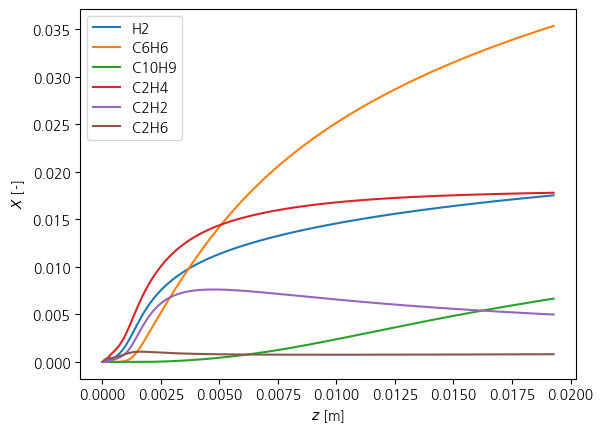

In [177]:
plt.figure()
plt.plot(z, states.Y[:,gas.species_index('H2(3)')], label='H2')
plt.plot(z, states.Y[:,gas.species_index('C6H6(6)')], label='C6H6')
plt.plot(z, states.Y[:,gas.species_index('C10H9(51)')], label='C10H9')
plt.plot(z, states.Y[:,gas.species_index('C2H4(5)')], label='C2H4')
plt.plot(z, states.Y[:,gas.species_index('C2H2(4)')], label='C2H2')
plt.plot(z, states.Y[:,gas.species_index('C2H6(33)')], label='C2H6')
plt.xlabel('$z$ [m]')
plt.ylabel('$X$ [-]')
plt.legend(loc=0)


In [178]:
t

array([ 0.        ,  0.01520122,  0.03040244, ..., 15.17081877,
       15.18601999, 15.20122121])

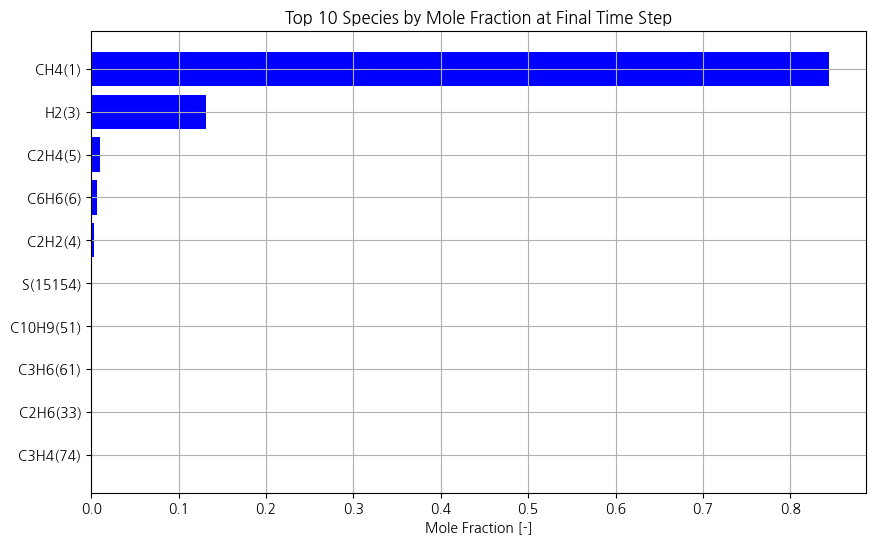

In [179]:
# 마지막 시점에서 모든 성분들의 몰 분율을 가져옵니다.
final_mole_fractions = states[-1].X

# 몰 분율이 큰 상위 10개 성분을 찾습니다.
top_10_species_indices = np.argsort(final_mole_fractions)[-10:]

# 상위 10개의 성분 이름과 그에 해당하는 몰 분율을 가져옵니다.
top_10_species_names = [gas.species_name(i) for i in top_10_species_indices]
top_10_mole_fractions = final_mole_fractions[top_10_species_indices]

# 상위 10개 성분의 몰 분율을 막대 그래프로 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(top_10_species_names, top_10_mole_fractions, color='blue')
plt.xlabel('Mole Fraction [-]')
plt.title('Top 10 Species by Mole Fraction at Final Time Step')
plt.grid(True)
plt.show()